In [132]:
import emoji
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [133]:
emoji_dict = emoji.EMOJI_UNICODE

In [134]:
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":beaming_face_with_smiling_eyes:",
                    "3": ":downcast_face_with_sweat:",
                    "4": ":fork_and_knife:",
                   }

In [135]:
for emo in emoji_dictionary.values():
    print(emoji.emojize(emo))

❤️
⚾
😁
😓
🍴


In [136]:
Training_data = pd.read_csv("Dataset/train_emoji.csv",header=None)
Testing_data = pd.read_csv("Dataset/test_emoji.csv",header=None)

In [137]:
Testing_data.head()

,0,1
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2
3,she got me a present\t,0
4,ha ha ha it was so funny\t,2


In [138]:
X_train,y_train  = Training_data.iloc[:,0].values,Training_data.iloc[:,1].values
X_test,y_test = Testing_data.iloc[:,0].values,Testing_data.iloc[:,1].values

In [139]:
for i in range(5):
    print(X_train[i],"--->",emoji.emojize(emoji_dictionary[str(y_train[i])]))

never talk to me again ---> 😓
I am proud of your achievements ---> 😁
It is the worst day in my life ---> 😓
Miss you so much ---> ❤️
food is life ---> 🍴


In [140]:
embeddings_index={}
with open("emojifier/services/emojifier/glove.6B.50d.txt",encoding='utf-8') as f:
    for line in f:
        value = line.split(" ")
        word = value[0]
        coef = np.asarray(value[1:],dtype = 'float32')
        embeddings_index[word] = list(coef)

In [141]:
def embedding_output(X):
    maxLen = 10
    emb_dim = 50
    embedding_out = np.zeros((X.shape[0],maxLen,emb_dim))
    
    for ix in range(X.shape[0]):
        X[ix] = X[ix].split()
        for ij in range(len(X[ix])):
            try:
                embedding_out[ix][ij] = embeddings_index[X[ix][ij].lower()]
            except:
                embedding_out[ix][ij] = np.zeros((emb_dim,))
    return embedding_out

In [142]:
embedding_matrix_train = embedding_output(X_train)
embedding_matrix_test = embedding_output(X_test)
y_train = to_categorical(y_train,num_classes=5)
y_test = to_categorical(y_test,num_classes=5)

In [143]:
model = Sequential()
model.add(LSTM(64,input_shape = (10,50),return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 64)            29440     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total params: 62,789
Trainable params: 62,789
Non-trainable params: 0
__________________________________________________

In [144]:
checkpoint = ModelCheckpoint("best_emoji_model.h5",monitor = 'val_loss',verbose=False,save_best_only= True)
earlyStop = EarlyStopping(monitor='val_loss',patience = 10)
history = model.fit(embedding_matrix_train,y_train,epochs=100,batch_size=64,shuffle=True,validation_split=0.1,callbacks=[checkpoint,earlyStop])

Train on 118 samples, validate on 14 samples
Epoch 1/100
118/118 [==============================] - 2s 18ms/step - loss: 1.6126 - accuracy: 0.2119 - val_loss: 1.5842 - val_accuracy: 0.2857
Epoch 2/100
118/118 [==============================] - 0s 787us/step - loss: 1.5850 - accuracy: 0.2797 - val_loss: 1.6000 - val_accuracy: 0.2857
Epoch 3/100
118/118 [==============================] - 0s 661us/step - loss: 1.5434 - accuracy: 0.3898 - val_loss: 1.6215 - val_accuracy: 0.2143
Epoch 4/100
118/118 [==============================] - 0s 586us/step - loss: 1.5279 - accuracy: 0.3729 - val_loss: 1.6410 - val_accuracy: 0.1429
Epoch 5/100
118/118 [==============================] - 0s 625us/step - loss: 1.5265 - accuracy: 0.2627 - val_loss: 1.6581 - val_accuracy: 0.1429
Epoch 6/100
118/118 [==============================] - 0s 630us/step - loss: 1.5122 - accuracy: 0.3390 - val_loss: 1.6667 - val_accuracy: 0.1429
Epoch 7/100
118/118 [==============================] - 0s 630us/step - loss: 1.5235 - 

In [145]:
y_pred = model.predict(embedding_matrix_test)

In [146]:
loss,test_acc = model.evaluate(embedding_matrix_test,y_test)

print(test_acc*100)

56/56 [==============================] - 0s 1ms/step
64.28571343421936


In [147]:
model.load_weights("best_emoji_model.h5")

In [148]:
loss,test_acc = model.evaluate(embedding_matrix_test,y_test)

print(test_acc*100)

56/56 [==============================] - 0s 232us/step
58.92857313156128


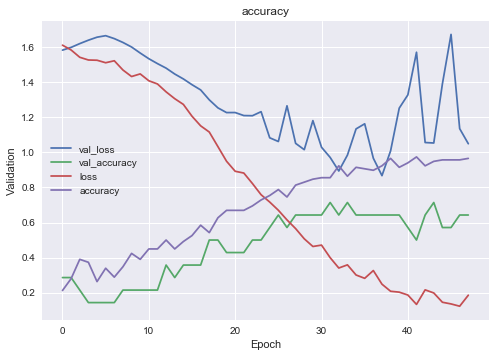

In [149]:
for key,values in (history.history).items():
    plt.plot(values,label = key)
    plt.xlabel("Epoch")
    plt.ylabel("Validation")
    plt.legend()
    plt.title(key)

In [150]:
y_pred = model.predict(embedding_matrix_test)
for i in range(30):
    print(" ".join(X_test[i]))
    print("Actual Emoji : ",emoji.emojize(emoji_dictionary[str(np.argmax(y_test[i]))]))
    print("Predicted Emoji : ",emoji.emojize(emoji_dictionary[str(np.argmax(y_pred[i]))]))
    print()

I want to eat
Actual Emoji :  🍴
Predicted Emoji :  🍴

he did not answer
Actual Emoji :  😓
Predicted Emoji :  😓

he got a raise
Actual Emoji :  😁
Predicted Emoji :  😓

she got me a present
Actual Emoji :  ❤️
Predicted Emoji :  ❤️

ha ha ha it was so funny
Actual Emoji :  😁
Predicted Emoji :  😁

he is a good friend
Actual Emoji :  ❤️
Predicted Emoji :  😁

I am upset
Actual Emoji :  ❤️
Predicted Emoji :  ⚾

We had such a lovely dinner tonight
Actual Emoji :  ❤️
Predicted Emoji :  😁

where is the food
Actual Emoji :  🍴
Predicted Emoji :  🍴

Stop making this joke ha ha ha
Actual Emoji :  😁
Predicted Emoji :  😁

where is the ball
Actual Emoji :  ⚾
Predicted Emoji :  ⚾

work is hard
Actual Emoji :  😓
Predicted Emoji :  😁

This girl is messing with me
Actual Emoji :  😓
Predicted Emoji :  ❤️

are you serious ha ha
Actual Emoji :  😁
Predicted Emoji :  😓

Let us go play baseball
Actual Emoji :  ⚾
Predicted Emoji :  ⚾

This stupid grader is not working
Actual Emoji :  😓
Predicted Emoji :  😓

work 

In [151]:
from sklearn.metrics import confusion_matrix

In [152]:
y_test = np.argmax(y_test,axis=1)
y_pred = np.argmax(y_pred,axis=1)

In [153]:
confMat = confusion_matrix(y_test,y_pred)

In [154]:
confMat

array([[7, 1, 3, 1, 0],
       [0, 5, 0, 0, 0],
       [2, 1, 9, 5, 1],
       [1, 3, 3, 8, 0],
       [0, 0, 1, 1, 4]], dtype=int64)

In [155]:
with open("best_emoji_model.json","w") as f:
    f.write(model.to_json())

In [156]:
from keras.models import model_from_json

In [157]:
with open("best_emoji_model.json","r") as f:
    model = model_from_json(f.read())
model.load_weights("best_emoji_model.h5")

In [158]:
test_str = "Hello how are you"
X = pd.Series([test_str])

In [159]:
emb_X = embedding_output(X)
p = model.predict_classes(emb_X)

In [160]:
print(p)

[2]


In [161]:
print(" ".join(X[0]))
print(emoji.emojize(emoji_dictionary[str(p[0])]))

Hello how are you
😁
